# Expana -- assignment interview

## Create a presentation where you describe the characteristics of this time series and explain how you expect it to evolve until the end of 2023.

### 1. Loading the libraries and the data

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

color_pale = sns.color_palette()
plt.style.use('seaborn-v0_8')

<Axes: title={'center': 'Exapana time series'}, xlabel='Date'>

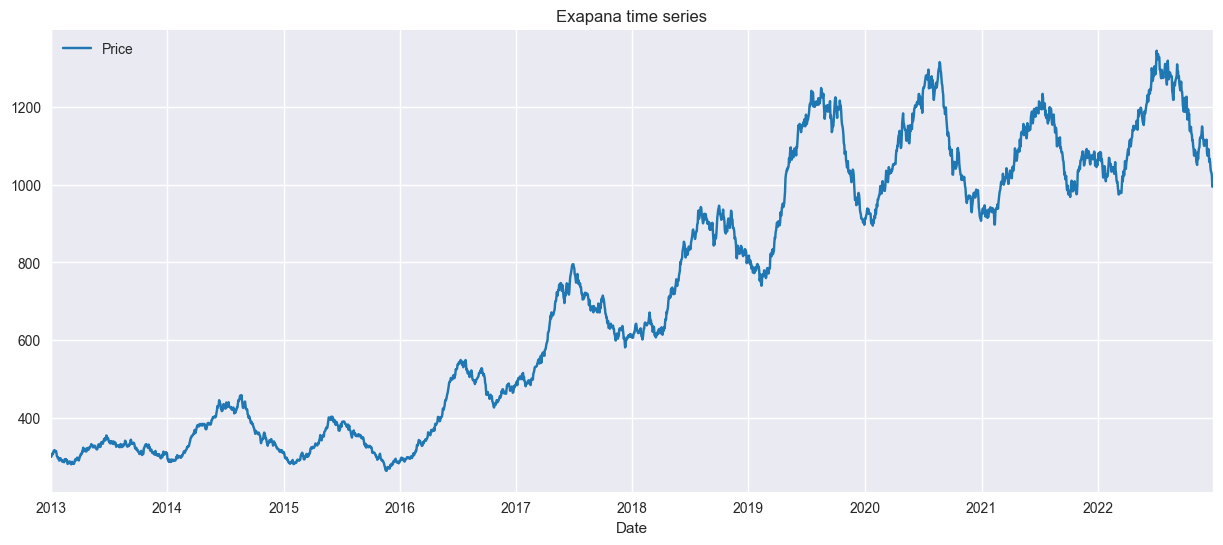

In [3]:
df = pd.read_excel("quantitative_analyst_case_Feb_2025.xlsx")
# date format: timstamp YYYY-mm-dd
df = df.set_index("Date")
df.plot(figsize=(15, 6), color = color_pale[0], title= "Exapana time series")

In [4]:
#checking the starting date and end date
df.index.min(), df.index.max()

(Timestamp('2012-12-31 00:00:00'), Timestamp('2022-12-30 00:00:00'))

### 1.1 Time series components
We know that time series is a combination of (maunly) three components:
- Trend: overall development of the series. It can consistently increase or decrease over time or a combination of both
- Seasonality: any seasonal pattern during the series
- Residuals whih have been always thought as statistical noise (random irregularity present in real-life data)

In [5]:
df = df.resample(rule = 'd').mean().ffill().asfreq('D')

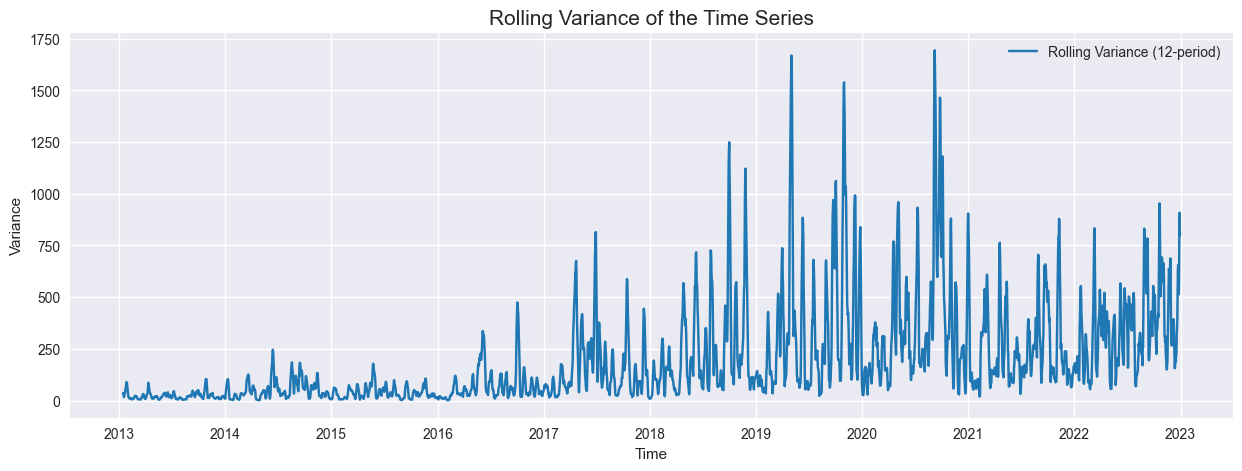

In [6]:
rolling_variance = df['Price'].rolling(window=15).var()

# Plotting the rolling variance
plt.figure(figsize=(15, 5))
plt.plot(rolling_variance, label='Rolling Variance (12-period)', color=color_pale[0])
plt.title('Rolling Variance of the Time Series', fontsize = 15)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.show()

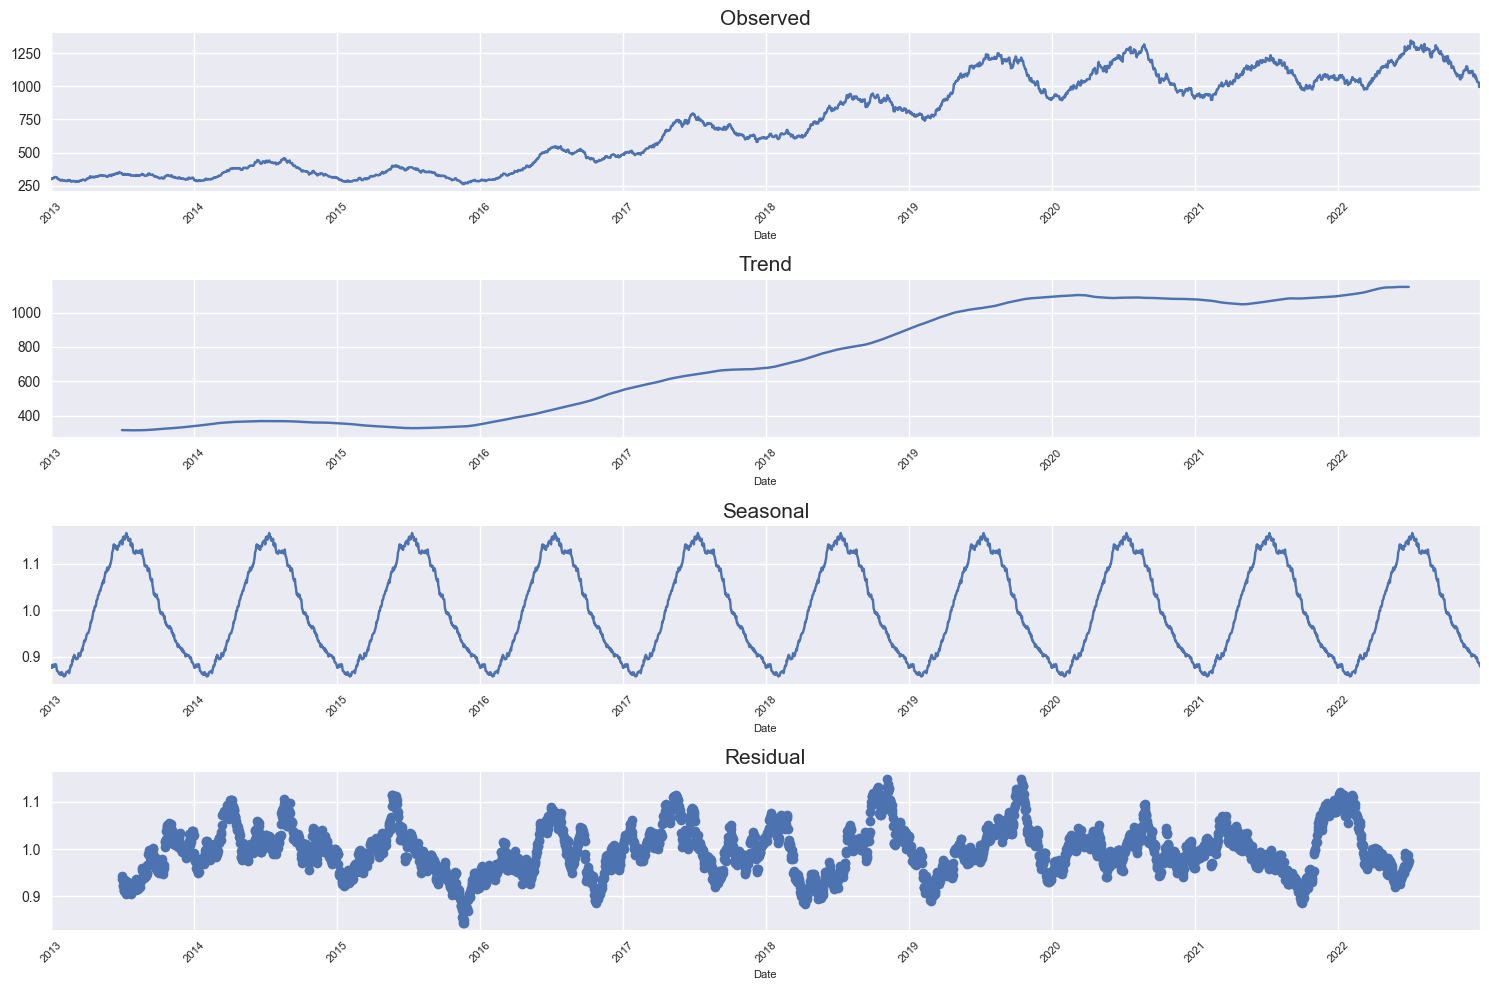

In [7]:
#no data for weekends etc. price from last non-null date is used to fill the data
decomposition_plot_multi = seasonal_decompose(df["Price"], model='multiplicative', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))  # Adjust figsize for width and height

decomposition_plot_multi.observed.plot(ax=axes[0])
axes[0].set_title('Observed', fontsize = 15)
axes[0].set_xlabel("Date", fontsize = 8)
axes[0].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.trend.plot(ax=axes[1])
axes[1].set_title('Trend', fontsize = 15)
axes[1].set_xlabel("Date", fontsize = 8)
axes[1].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal', fontsize = 15)
axes[2].set_xlabel("Date", fontsize = 8)
axes[2].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.resid.plot(ax=axes[3], linestyle='None', marker = 'o')
axes[3].set_title('Residual', fontsize = 15)
axes[3].set_xlabel("Date", fontsize = 8)
axes[3].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed


plt.tight_layout() # Important: Adjusts subplot params for a tight layout
plt.show()

### 2. Applaying feature engineering

In [8]:
def create_features(df):   
    """
    Create additional features from the date index
    """
    df["dayofweek"] = df.index.day_of_week.astype(int)
    df["dayofyear"] = df.index.day_of_year.astype(int)
    df["month"] = df.index.month.astype(int)
    df["quarter"] = df.index.quarter.astype(int)
    df["year"] = df.index.year.astype(int)

    return df

df = create_features(df)

In [9]:
df

,Price,dayofweek,dayofyear,month,quarter,year
Date,,,,,,
2012-12-31,300.000000,0,366,12,4,2012
2013-01-01,299.553248,1,1,1,1,2013
2013-01-02,302.043389,2,2,1,1,2013
2013-01-03,307.849084,3,3,1,1,2013
2013-01-04,307.091766,4,4,1,1,2013
...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,12,4,2022
2022-12-27,1022.667013,1,361,12,4,2022
2022-12-28,994.676194,2,362,12,4,2022


### 3. Visualize feature/target relationship

C:\Users\matte\AppData\Local\Temp\ipykernel_1276\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_1276\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_1276\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


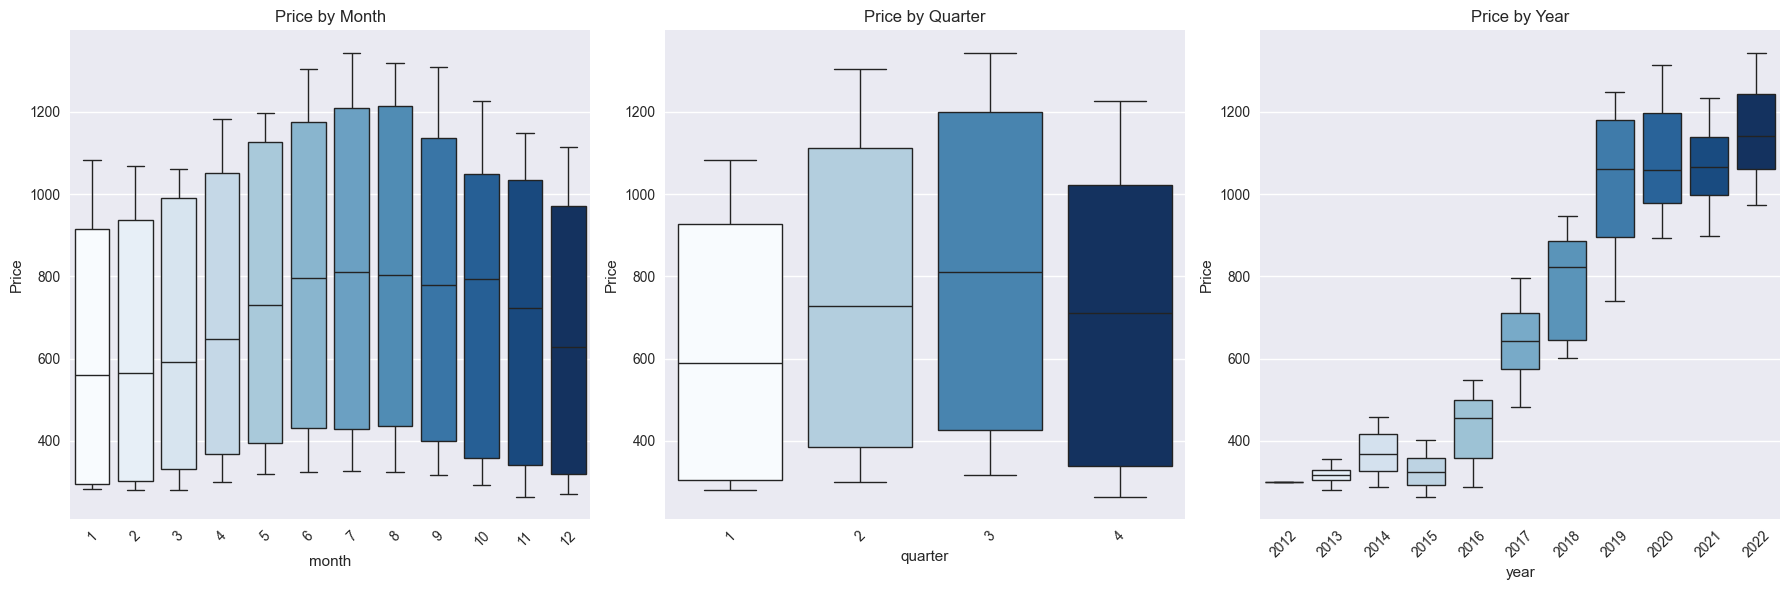

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Boxplot by Month ---
sns.boxplot(data=df, x="month", y="Price", ax=axes[0], hue = "month", legend= False, palette="Blues")
axes[0].set_title("Price by Month")

# Boxplot by Quarter ---
sns.boxplot(data=df, x="quarter", y="Price", ax=axes[1], hue = "quarter", legend= False, palette="Blues")
axes[1].set_title("Price by Quarter")

# Boxplot by Year ---
sns.boxplot(data=df, x="year", y="Price", ax=axes[2], hue = "year", legend= False, palette="Blues")
axes[2].set_title("Price by Year")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 4. Train test split

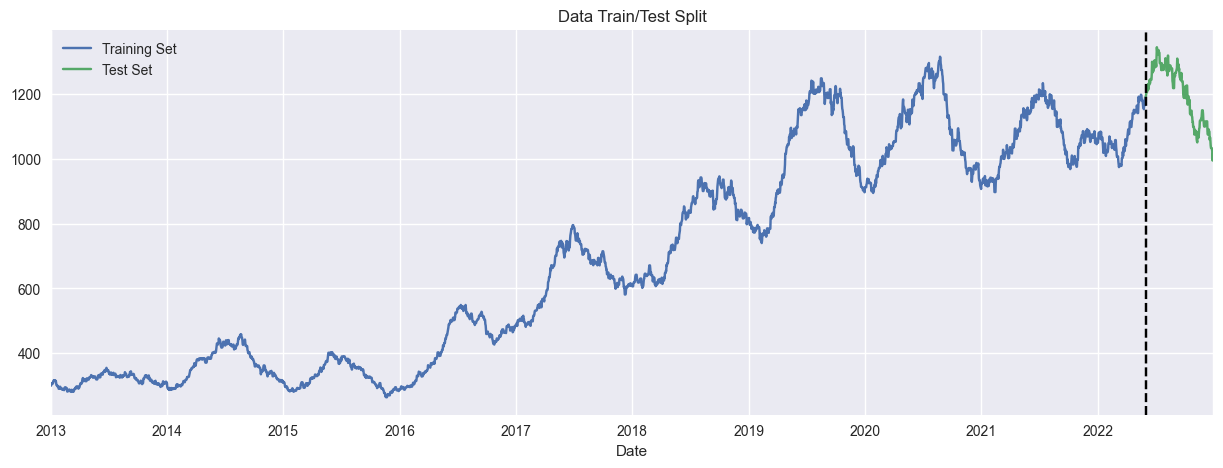

In [16]:
train = df.loc[df.index < '2022-06-01']["Price"]
test = df.loc[df.index >= '2022-06-01']["Price"]

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot both training and testing data (assume you want to plot the entire dataframe)
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')

# Add vertical line at the split point
ax.axvline(pd.to_datetime('2022-06-01'), color='black', ls='--')

# Add legend and title
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/Test Split')

# Show the plot
plt.show()

In [13]:
df.index

DatetimeIndex(['2012-12-31', '2013-01-01', '2013-01-02', '2013-01-03',
               '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07',
               '2013-01-08', '2013-01-09',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')